In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE


In [14]:
# fetal_health.csv is in the same directory
data = pd.read_csv('fetal_health.csv')

# Quick look
print(data.head())
print(data['fetal_health'].value_counts())


   baseline value  accelerations  fetal_movement  uterine_contractions   
0           120.0          0.000             0.0                 0.000  \
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations   
0                0.000                   0.0                       0.0  \
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability   
0                             73.0

In [15]:
# Features and labels
X = data.drop('fetal_health', axis=1)
y = data['fetal_health']

y = y - 1

# Stratify ensures class proportions are maintained
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:", np.bincount(y_train_smote))


Class distribution after SMOTE: [1323 1323 1323]


In [16]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Metrics
print("XGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Classifier Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       332
         1.0       0.86      0.75      0.80        59
         2.0       0.84      0.91      0.88        35

    accuracy                           0.94       426
   macro avg       0.89      0.88      0.88       426
weighted avg       0.94      0.94      0.94       426

Accuracy: 0.9389671361502347


In [17]:
# One-hot encoding for neural network
y_train_nn_smote = to_categorical(y_train_smote, num_classes=3)
y_test_nn = to_categorical(y_test, num_classes=3)

# Build simple NN
nn_model = Sequential()
nn_model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(3, activation='softmax'))

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = nn_model.fit(X_train_smote, y_train_nn_smote, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Predict
y_pred_nn_probs = nn_model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_nn_probs, axis=1)

print("Neural Network Classifier Report:")
print(classification_report(y_test, y_pred_nn))
print("Accuracy:", accuracy_score(y_test, y_pred_nn))


Epoch 1/30
100/100 [==============================] - 1s 4ms/step - loss: 0.6850 - accuracy: 0.7427 - val_loss: 0.6131 - val_accuracy: 0.7179
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4265 - accuracy: 0.8454 - val_loss: 0.3936 - val_accuracy: 0.8300
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3703 - accuracy: 0.8605 - val_loss: 0.4683 - val_accuracy: 0.8123
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3349 - accuracy: 0.8803 - val_loss: 0.4283 - val_accuracy: 0.8287
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3135 - accuracy: 0.8844 - val_loss: 0.2807 - val_accuracy: 0.8514
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2914 - accuracy: 0.8898 - val_loss: 0.3069 - val_accuracy: 0.8463
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2822 - accuracy: 0.8920 - val_loss: 0.2494 - val_accuracy: 0.8665
Epoch 

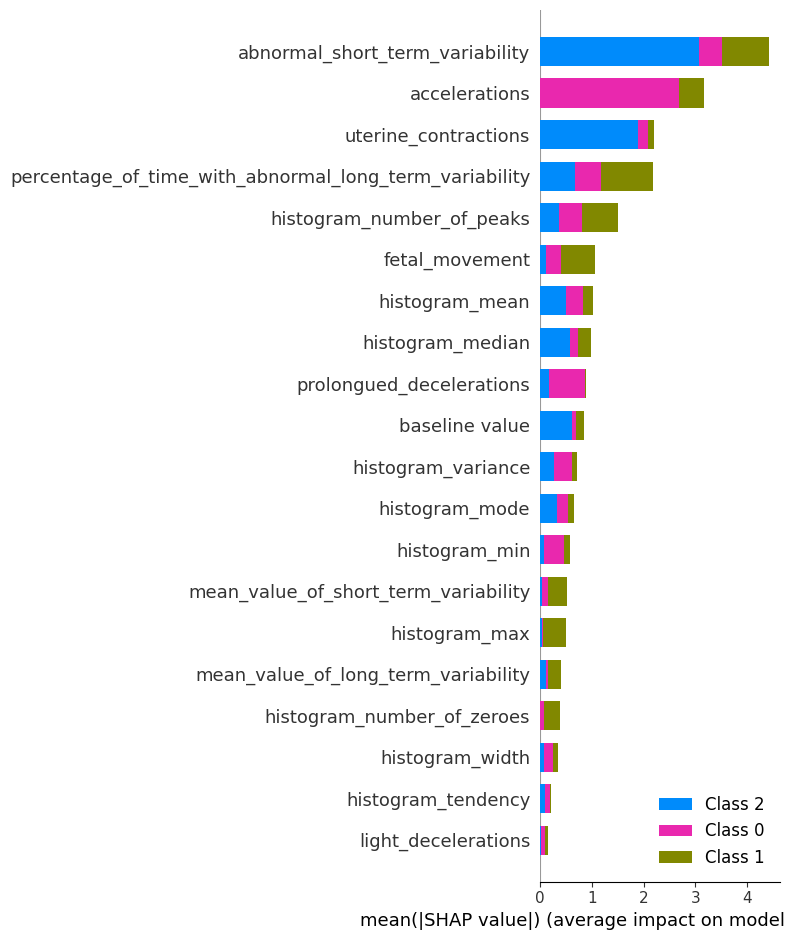

In [18]:
# SHAP explainability
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Save the SHAP plot
plt.savefig('shap_summary.png')
plt.close()


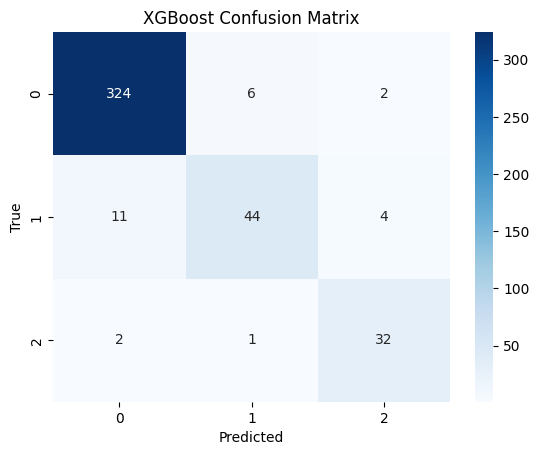

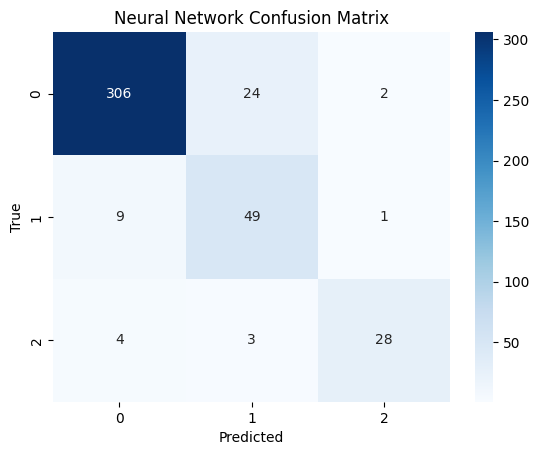

In [19]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Confusion matrix for XGBoost
plot_conf_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

# Confusion matrix for Neural Network
plot_conf_matrix(y_test, y_pred_nn, "Neural Network Confusion Matrix")
